# Univariate Time Series Model of Wind Generation

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

from datetime import datetime, timedelta

%matplotlib inline
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.optimizers import Adam


import warnings
warnings.simplefilter(action="ignore")

In [48]:
df = pd.read_csv('../../data/final_dfs/combined_final.csv')
temp_df = pd.read_csv('../../data/texas_temp.csv')

In [49]:
df.head()

,date,Biomass,Coal,Hydro,Nuclear,Other,Solar,Wind,NGas
0,2011-01-01,1240.848016,304483.8981,670.712237,90516.91023,357.449324,70.651290,123213.38820,248086.36399
1,2011-01-02,1478.590690,320703.6726,667.009668,90462.21494,372.626928,10.255158,62531.39844,268971.64998
2,2011-01-03,1483.246127,296436.2237,741.426017,90472.37075,401.536782,15.155827,89515.57352,222285.00985
3,2011-01-04,1411.010006,322214.6377,683.281626,90312.68708,478.415477,5.278214,59542.48570,271747.93685
4,2011-01-05,1348.331266,308136.0801,623.145421,90280.19160,440.383112,22.997359,128920.84250,358001.80005


In [50]:
temp_df.head()

,Date,Temp
0,1/1/11,45.0
1,2/1/11,48.7
2,3/1/11,61.8
3,4/1/11,70.3
4,5/1/11,74.1


In [51]:
df = df[['date', 'NGas']]

df['date']=pd.to_datetime(df['date'])

df = df[df['date'].dt.day == 1]

df.reset_index(inplace=True)

df.drop(columns='index',inplace=True)

df_full = pd.concat([df, temp_df], axis =1)

In [52]:
df_full

,date,NGas,Date,Temp
0,2011-01-01,248086.363990,1/1/11,45.0
1,2011-02-01,218819.159530,2/1/11,48.7
2,2011-03-01,343441.973030,3/1/11,61.8
3,2011-04-01,202053.382820,4/1/11,70.3
4,2011-05-01,472446.061500,5/1/11,74.1
...,...,...,...,...
115,2020-08-01,721716.604984,8/1/20,84.3
116,2020-09-01,651271.628603,9/1/20,74.0
117,2020-10-01,445206.272739,10/1/20,65.9
118,2020-11-01,347772.901358,11/1/20,60.6


In [12]:
train_dates = pd.to_datetime(df['date'])
df_full.drop(columns='Date',inplace=True)
df_full.set_index('date', inplace=True)

In [13]:
df_full

,NGas,Temp
date,,
2011-01-01,248086.363990,45.0
2011-02-01,218819.159530,48.7
2011-03-01,343441.973030,61.8
2011-04-01,202053.382820,70.3
2011-05-01,472446.061500,74.1
...,...,...
2020-08-01,721716.604984,84.3
2020-09-01,651271.628603,74.0
2020-10-01,445206.272739,65.9


### Because Natural Gas and Temperautre are on such different scales, let's apply a standard scaler

In [14]:
df_full

,NGas,Temp
date,,
2011-01-01,248086.363990,45.0
2011-02-01,218819.159530,48.7
2011-03-01,343441.973030,61.8
2011-04-01,202053.382820,70.3
2011-05-01,472446.061500,74.1
...,...,...
2020-08-01,721716.604984,84.3
2020-09-01,651271.628603,74.0
2020-10-01,445206.272739,65.9


In [15]:
X = df_full
y = df_full['NGas'].values

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, shuffle = False)

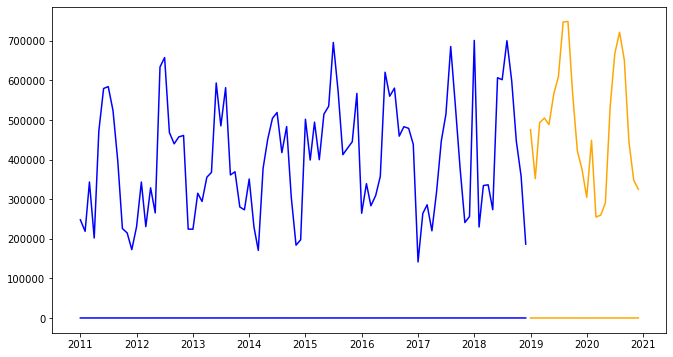

In [17]:
plt.figure(figsize =(11, 6))
plt.plot(X_train, c='blue')
plt.plot(X_test, c ='orange')

## Scaling

In [18]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

## Preprocessing

In [19]:
train_sequences = TimeseriesGenerator(data=X_train_sc, 
                                      targets=y_train, 
                                      length=12, 
                                      batch_size=64
                                     )

In [20]:
batch_x, batch_y = train_sequences[0]

In [21]:
batch_x.shape, batch_y.shape

((64, 12, 2), (64,))

In [22]:
batch_y

array([230633.60128 , 343284.6707  , 230778.63079 , 328803.31586 ,
       265461.7189  , 633911.1637  , 657775.662288, 468612.471618,
       439868.47438 , 457395.036436, 460994.187611, 224452.14667 ,
       224257.768453, 315074.775346, 294264.038961, 355487.858627,
       367687.432921, 593611.652038, 485258.866024, 581785.40821 ,
       361268.755898, 369355.70349 , 280482.41753 , 273124.78915 ,
       350988.862158, 229785.093907, 170839.19915 , 377498.308259,
       451123.973953, 504339.804372, 519015.960654, 417636.140016,
       483462.309968, 305324.999221, 183995.569241, 197401.246652,
       501883.615674, 398884.558757, 494579.537356, 399816.199308,
       514852.060724, 534897.688995, 695866.78166 , 573199.712889,
       412485.481199, 428780.798677, 445191.49479 , 567154.266676,
       264575.306995, 339240.800614, 283403.429376, 309263.662298,
       357666.871278, 620681.474475, 560123.362821, 580548.834455,
       459298.654695, 483083.449083, 479015.033501, 438688.033

In [23]:
test_sequences = TimeseriesGenerator(data=X_test_sc, 
                                      targets=y_test, 
                                      length=12, 
                                      batch_size=64
                                     )

In [24]:
input_shape = train_sequences[0][0][0].shape

### Reshape our data

In [42]:
model = Sequential()
model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1, activation='linear'))

model.compile(optimizer= Adam(learning_rate=0.01), loss='mse')
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 12, 64)            17152     
_________________________________________________________________
lstm_19 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 29,601
Trainable params: 29,601
Non-trainable params: 0
_________________________________________________________________


In [43]:
history= model.fit(train_sequences, validation_data =test_sequences, epochs=10, verbose=1)

Epoch 1/10
2/2 [==============================] - 3s 744ms/step - loss: 197078362794.6667 - val_loss: 217619415040.0000
Epoch 2/10
2/2 [==============================] - 0s 97ms/step - loss: 182973934250.6667 - val_loss: 217617006592.0000
Epoch 3/10
2/2 [==============================] - 0s 81ms/step - loss: 182971629568.0000 - val_loss: 217614516224.0000
Epoch 4/10
2/2 [==============================] - 0s 139ms/step - loss: 182969455957.3333 - val_loss: 217613254656.0000
Epoch 5/10
2/2 [==============================] - 0s 61ms/step - loss: 182968445610.6667 - val_loss: 217612533760.0000
Epoch 6/10
2/2 [==============================] - 0s 61ms/step - loss: 197071192064.0000 - val_loss: 217611943936.0000
Epoch 7/10
2/2 [==============================] - 0s 66ms/step - loss: 197070640469.3333 - val_loss: 217611370496.0000
Epoch 8/10
2/2 [==============================] - 0s 71ms/step - loss: 197069963264.0000 - val_loss: 217610780672.0000
Epoch 9/10
2/2 [==============================

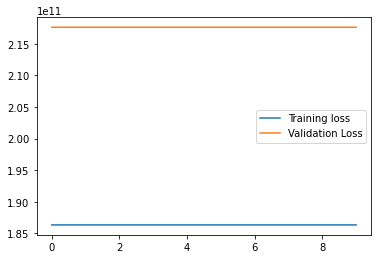

In [36]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

In [44]:
n_forecast = 24  # period length of forecasts - in this case, months

# create a list of dates based on training dates, start at first training date and create list of length n_forecast
forecast_period_dates = pd.date_range(start=list(df_full.index)[-1], periods=n_forecast, freq='MS').tolist()   

### Instantiate and Fit our Model

In [55]:
train_sequences[0][0].shape

(64, 11, 2)

In [56]:
input_shape = train_sequences[0][0][0].shape

In [57]:
input_shape

(11, 2)

In [68]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=input_shape, return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 11, 64)            17152     
_________________________________________________________________
lstm_16 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 29,601
Trainable params: 29,601
Non-trainable params: 0
_________________________________________________________________


In [69]:
history= model.fit(X_train_sc, y_train, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/10


ValueError: in user code:

    /Users/andrewroberts/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /Users/andrewroberts/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/andrewroberts/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/andrewroberts/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/andrewroberts/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/andrewroberts/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /Users/andrewroberts/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /Users/andrewroberts/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/andrewroberts/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_10 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 2)


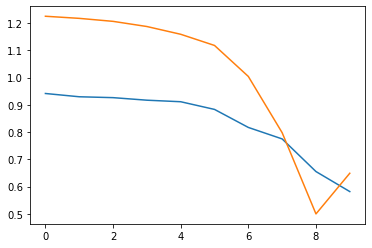

In [345]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

In [346]:
n_forecast = 24  # period length of forecasts - in this case, months

# create a list of dates based on training dates, start at first training date and create list of length n_forecast
forecast_period_dates = pd.date_range(start=list(train_dates)[-1], periods=n_forecast, freq='MS').tolist()   

In [347]:
forecast_period_dates

[Timestamp('2020-12-01 00:00:00', freq='MS'),
 Timestamp('2021-01-01 00:00:00', freq='MS'),
 Timestamp('2021-02-01 00:00:00', freq='MS'),
 Timestamp('2021-03-01 00:00:00', freq='MS'),
 Timestamp('2021-04-01 00:00:00', freq='MS'),
 Timestamp('2021-05-01 00:00:00', freq='MS'),
 Timestamp('2021-06-01 00:00:00', freq='MS'),
 Timestamp('2021-07-01 00:00:00', freq='MS'),
 Timestamp('2021-08-01 00:00:00', freq='MS'),
 Timestamp('2021-09-01 00:00:00', freq='MS'),
 Timestamp('2021-10-01 00:00:00', freq='MS'),
 Timestamp('2021-11-01 00:00:00', freq='MS'),
 Timestamp('2021-12-01 00:00:00', freq='MS'),
 Timestamp('2022-01-01 00:00:00', freq='MS'),
 Timestamp('2022-02-01 00:00:00', freq='MS'),
 Timestamp('2022-03-01 00:00:00', freq='MS'),
 Timestamp('2022-04-01 00:00:00', freq='MS'),
 Timestamp('2022-05-01 00:00:00', freq='MS'),
 Timestamp('2022-06-01 00:00:00', freq='MS'),
 Timestamp('2022-07-01 00:00:00', freq='MS'),
 Timestamp('2022-08-01 00:00:00', freq='MS'),
 Timestamp('2022-09-01 00:00:00', 

In [348]:
# make predictions on our model based on the training data. Use  
forecast = model.predict(trainX[-n_forecast:])

In [349]:
forecast_copies = np.repeat(forecast, df_train.shape[1], axis=-1)


In [350]:
y_pred_future = sc.inverse_transform(forecast_copies)[:,0]  # Take

In [351]:
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [352]:
len(y_pred_future)

24

In [353]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'NGas':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [354]:
original = pd.DataFrame(df_full[['date', 'NGas']])


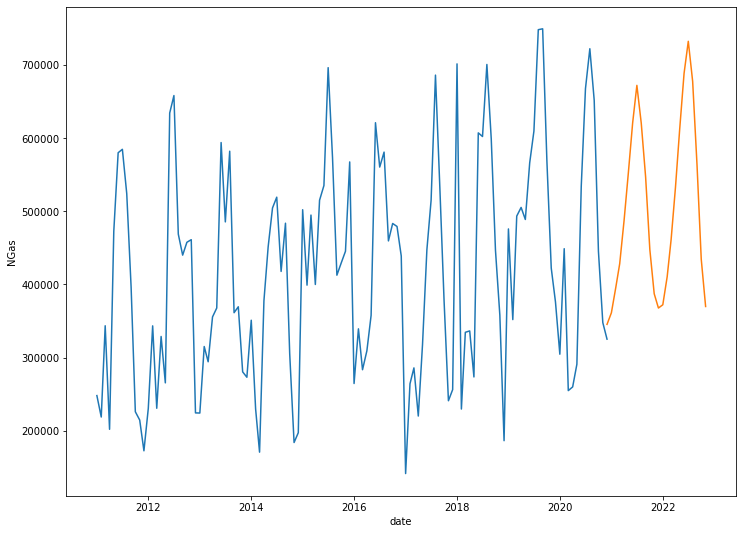

In [355]:
plt.figure(figsize=(12,9))
sns.lineplot(original['date'], original['NGas']);
sns.lineplot(df_forecast['Date'], df_forecast['NGas']);